In [1]:
import os
#import sys

import wfdb

#import time

import numpy as np
#from numpy.linalg import norm
from numpy.linalg import inv
#import random as rnd
#import math as mth

import scipy.signal as scsig
#import scipy.linalg as sclin
import matplotlib.pyplot as plt
# import scipy.stats as scstat
# import scipy.ndimage as scndi

In [2]:
%run BaselineWonderRemoval.ipynb
%run RPeakDetector.ipynb
%run MiddleDetector.ipynb
%run RPeakReordering.ipynb
%run AddNoise.ipynb
%run ECGHeartBeatsList.ipynb
%run CheckThetaThetaTransposed.ipynb
%run CheckSampleCovarianceMatrix.ipynb
%run ComputeMinAndMaxHeartbeatLength.ipynb

%run MeanECGExtraction.ipynb

In [3]:
#srecord = wfdb.rdrecord('Data/s0010_re')
FILE_PATH = os.getcwd()
data_dir = FILE_PATH + '/../QTDataBase/'
data_files = os.listdir(data_dir) # get a listing of the directory
dat_files = [x.split('.')[0] for x in data_files]
#dat_files = sorted([f for f in data_files if f.endswith('.hea')]) # get a list of all the .atc files
#-------
file_name = 'sele0612'
#'sele0603' 'sele0612' 'sel41' 'sele0122' 'sel40' 'sele0612' 'sele0303'
#-------
file_to_read = data_dir + file_name
signals, fields = wfdb.rdsamp(file_to_read, sampfrom=0)
fs = fields["fs"]
ch_num = 0
s = signals[:,ch_num]
#
#-------
n_sec = 500
N = n_sec * fs 
ecg_clean = s[0: N]
tm = np.arange(0, N)/fs
#-------
bwr, ecg_bwr = BaselineWonderRemoval(signal = ecg_clean,
                                     win_l_MA = 0.5,
                                     win_l_MD = 0.71,
                                     fs = fs)
ecg_bp1, ecg_bp, ecg_tan, ecg_sq, ecg_MA_sq, peaks2, pks = RPeakDetector(signal = ecg_bwr, 
                                                                             frac = 0.5, 
                                                                             win_l_calib = 0.6, 
                                                                             win_l_peak_search = 0.5, 
                                                                             fs = fs)
mids = MiddleDetector(peaks2, len(ecg_bwr))
pks = RPeakReordering(pks, mids)

ecg = ecg_bwr[mids[0] : mids[-1]+1]                # get the ecg, i.e. get the chunck between the first mid and last mid
ps = np.int_(pks - mids[0])                        # calibrate the peaks, by shifting with the mids[0] 
                                                   # which is the begining of the signal
    
ms = np.int_(mids - mids[0])                       # calibrate the midles, by shifting with the mids[0] 
                                                   # which is the begining of the signal

pshb = ps - ms[:-1]                                # the peaks relative to each heartbeat, i.e. the position counting 
                                                   # from the heartbeat begining    
#----- ---- --- -- -
target_noise_db = 0                                # set the target noise in dB
Tau = 250                                          # set the number of bins (samples in phase space)
ecg_n, n, var_n = AddNoise(target_noise_db, ecg)   # get the noisy signal and the added noise signal
sd_n = np.sqrt(var_n)
#----- ---- --- -- -
x = ECGHeartBeatsList(ecg, ms)                     # x is the "pure" ecg, as list of heartbeats
x_f = np.concatenate(x, axis=0).tolist()           # x_f refers to x flatten, used in multiplications
#----- ---- --- -- -
x_n = ECGHeartBeatsList(ecg_n, ms)                 # x is the "noisy" ecg, as list of noisy heartbeats
x_n_f = np.concatenate(x_n, axis=0).tolist()       # x_n_f refers to x_n flatten, used in multiplications

print("selected file: ", file_name)
print("selected channel: ", ch_num)
print('number of seconds:', n_sec)
print('N = ',N)
print('# of samples in x: ', len(x_f))
print('# of hb in x: ', len(x))
print('smallest hb in x:', ComputeMinAndMaxHeartbeatLength(x)[0])
print('largest hb in x:', ComputeMinAndMaxHeartbeatLength(x)[1])
print('target noise dB:', target_noise_db)
print('noise variance:', var_n)
print('Tau:', Tau)
CheckThetaThetaTransposed(x, Tau)
CheckSampleCovarianceMatrix(x, Tau)

selected file:  sele0612
selected channel:  0
number of seconds: 500
N =  125000
# of samples in x:  124561
# of hb in x:  412
smallest hb in x: 278
largest hb in x: 319
target noise dB: 0
noise variance: 0.06826489783005411
Tau: 250
[OK] Tau = 250 <= 278 = min(len(hb)) => Theta * Theta.T is diagonal hence invertible.
[OK] Tau = 250 <= 412 = n_hb => sampCov most probably invertible


In [4]:
%run ComputeECGPhaseAndThetaList.ipynb
%run ComputeTheta.ipynb
%run ComputeSampleCovariances.ipynb

In [5]:
#x in phase domain 
xph, Th = ComputeECGPhaseAndThetaList(x, pshb, Tau)  # xph is list of transformed heartbeats for x, Theta is the transf
Theta = ComputeTheta(Th)                             # Theta is formed from each Th_i, by concatenation and normalization

In [6]:
len(Theta[0].tolist())

124561

In [7]:
# # Theta is filtered for a smoother filter
# %run MovingAverageMatrixFilter.ipynb
# ThetaF = MovingAverageMatrixFilter(Theta, 5)

In [8]:
xph_f = np.concatenate(xph, axis=0).tolist()         # xph_f refers to xph flatten, used in multiplications
mu_xph = np.matmul(Theta, x_f)
#mu_xph = np.asarray(Theta * np.asmatrix(x_f).T)      # mu_xph is the mean-binned signal x in the phase domain

In [9]:
S_xph, S_sph, var_xph, var_sph = ComputeSampleCovariances(xph, var_n)
sd_xph = np.sqrt(var_xph)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


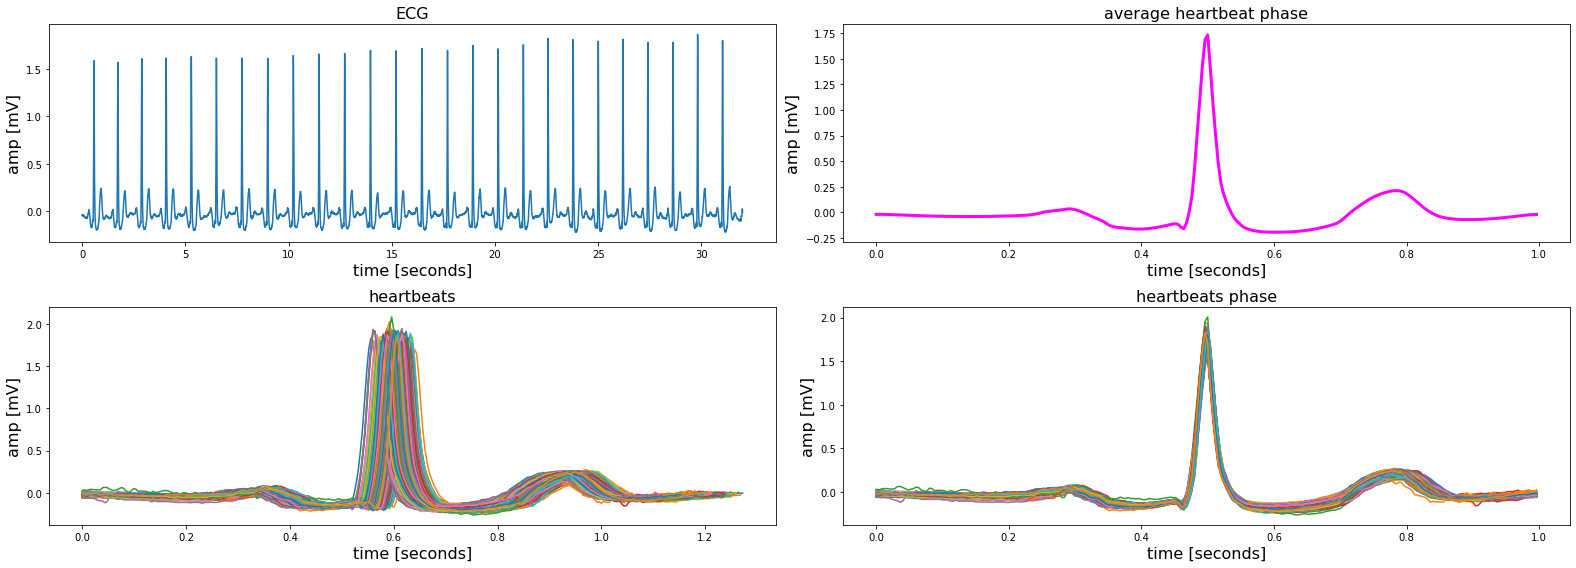

In [10]:
%run PlotTransitionECG.ipynb
target_file = '../Figs/pISCE_GP_TransFS2'
PlotTransitionECG(x, xph, mu_xph, var_xph, fs, target_file)

In [11]:
B = np.matmul(Theta, Theta.T)
invB = np.linalg.inv(B) 
BinvB = np.matmul(B,invB)

In [12]:
%run ComputeSampleCovariances.ipynb
Sxph, Ssph, varxph, varsph = ComputeSampleCovariances(xph, var_n)
invSxph = np.linalg.inv(Sxph) 
SxphinvSxph = np.matmul(Sxph,invSxph)

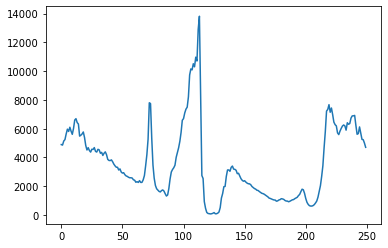

In [13]:
plt.plot(1/varxph)

In [14]:
# %run ComputeSampleCovariances2.ipynb
# samps2, Sxph2, Ssph2, varxph2, varsph2 = ComputeSampleCovariances2(xph, var_n)
# invSxph2 = np.linalg.inv(Sxph2) 
# SxphinvSxph2 = np.matmul(Sxph2,invSxph2)

In [15]:
# Rho = invB 
# Rho = invB - var_n * invSxph
# Rho = B - var_n * Sxph
Rho = invB - var_n * np.diag(1/np.diag(Sxph))

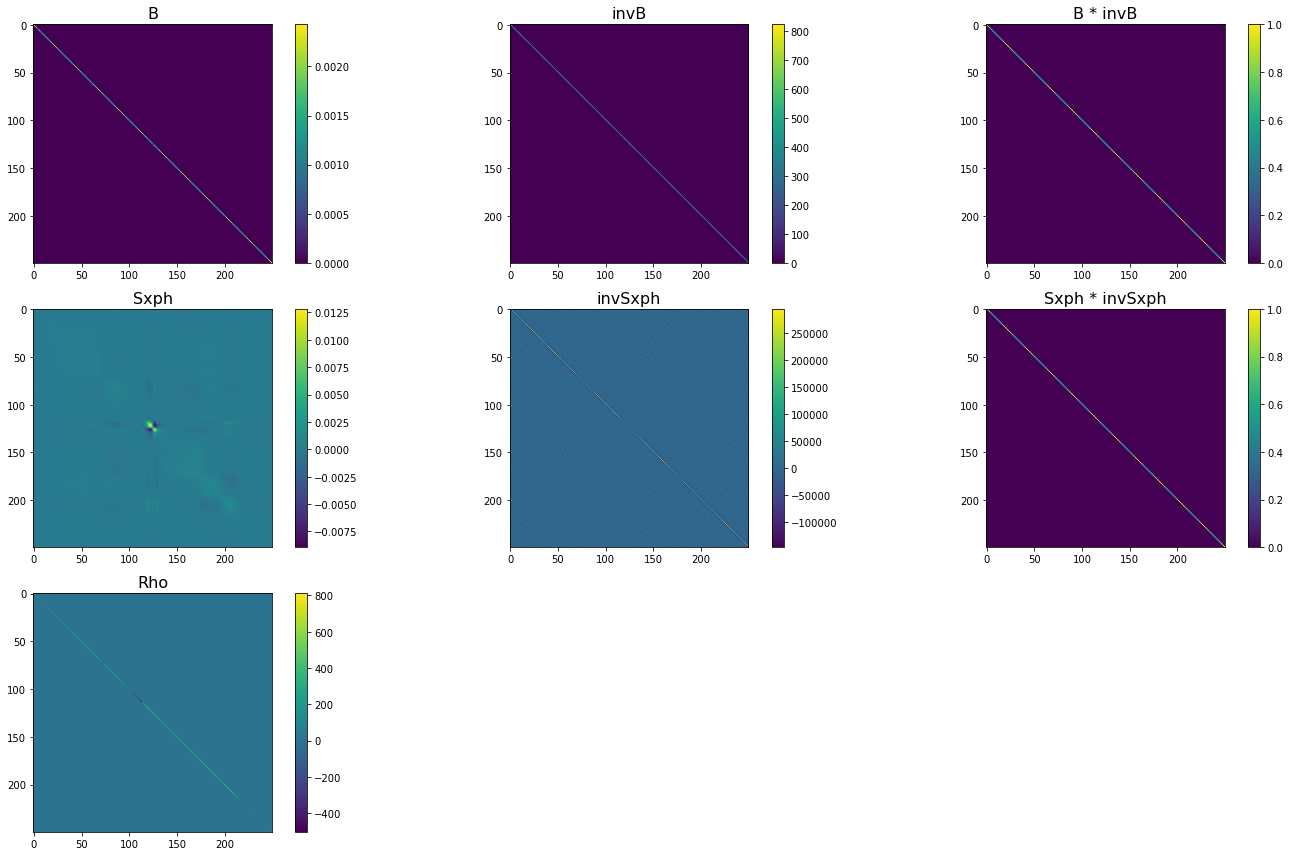

In [16]:
fig = plt.figure(figsize = (20,12))    
#-----
plt.subplot(3,3,1)
plt.imshow(B)
plt.colorbar()
plt.title("B", fontsize = 16)
#-----
plt.subplot(3,3,2)
plt.imshow(invB)
plt.colorbar()
plt.title("invB", fontsize = 16)
#-----
plt.subplot(3,3,3)
plt.imshow(BinvB)
plt.colorbar()
plt.title("B * invB", fontsize = 16)
#-----
plt.subplot(3,3,4)
plt.imshow(Sxph)
plt.colorbar()
plt.title("Sxph", fontsize = 16)
#-----
plt.subplot(3,3,5)
plt.imshow(invSxph)
plt.colorbar()
plt.title("invSxph", fontsize = 16)
#-----
plt.subplot(3,3,6)
plt.imshow(SxphinvSxph)
plt.colorbar()
plt.title("Sxph * invSxph", fontsize = 16)
#-----
plt.subplot(3,3,7)
plt.imshow(Rho)
plt.colorbar()
plt.title("Rho", fontsize = 16)
#-----
fig.tight_layout()

In [17]:
ts = np.matmul(invB, Theta)
#ts = np.matmul(Theta.T, np.matmul(invB, Theta))

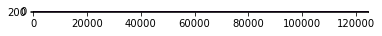

In [18]:
plt.imshow(ts)

In [19]:
%run ComputeECGmean.ipynb

mu_x = ComputeECGmean(Theta, invB, mu_xph)
mu_xtest = ComputeECGmean(Theta, np.identity(Tau), mu_xph)

diff = [x_f_elem - mu_x_elem for (x_f_elem, mu_x_elem) in zip(x_f, mu_x)]
diff_n = [x_n_f_elem - mu_x_elem for (x_n_f_elem, mu_x_elem) in zip(x_n_f, mu_x)]
beta = np.matmul(Theta.T, np.matmul(Rho, np.matmul(Theta, diff_n)))

s_h = [mu_x_elem + beta_elem for (mu_x_elem, beta_elem) in zip(mu_x, beta)]

In [20]:
# detail = 1000
# fig = plt.figure(figsize = (20,11))    
# #-----
# plt.subplot(4, 2, 1)
# plt.plot(x_f[0 : detail])
# plt.title("x_f", fontsize = 16)
# #-----
# plt.subplot(4, 2, 2)
# plt.plot(x_n_f[0 : detail])
# plt.title("x_n_f", fontsize = 16)
# #-----
# plt.subplot(4, 2, 3)
# plt.plot(mu_x[0 : detail])
# #plt.plot(mu_xtest[0:detail])
# plt.title("mu_x", fontsize = 16)
# #-----
# plt.subplot(4, 2, 4)
# plt.plot(diff_n[0 : detail])
# plt.title("x_n_f - mu_x", fontsize = 16)
# #-----
# plt.subplot(4, 2, 5)
# plt.plot(x_f[0 : detail])
# plt.plot(mu_x[0 : detail])
# plt.legend(['x_f', 'mu_x'])
# plt.title("x_f vs. mu_x", fontsize = 16)
# #-----
# plt.subplot(4, 2, 6)
# plt.plot(diff[0 : detail])
# plt.title("x - mu_x", fontsize = 16)
# #-----
# plt.subplot(4, 2, 7)
# plt.plot(beta[0 : detail])
# plt.title("beta", fontsize = 16)
# #-----
# plt.subplot(4, 2, 8)
# plt.plot(x_f[0 : detail])
# plt.plot(s_h[0 : detail])
# plt.legend(['x_f', 's_h'])
# plt.title("s_h", fontsize = 16)
# #-----
# fig.tight_layout()

In [21]:
%run ComputeInputOutputDeltaSNRs.ipynb
print(ComputeInputOutputDeltaSNRs(x_f, n, mu_x))
print(ComputeInputOutputDeltaSNRs(x_f, n, s_h))

(0.01620409162242241, 15.430070640615657, 15.413866548993235)
(0.01620409162242241, 15.322777544387524, 15.306573452765102)


In [22]:
tst = np.matmul(Theta, x_f)

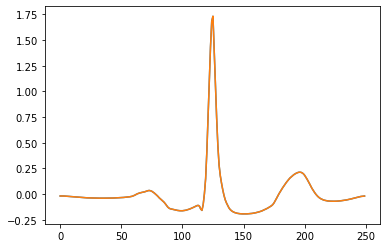

In [23]:
plt.plot(tst)
plt.plot(mu_xph)

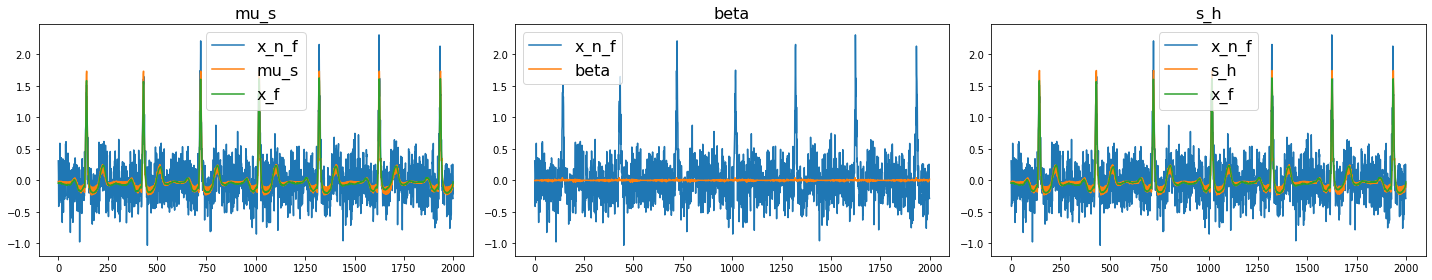

In [24]:
detail = 2000
fig = plt.figure(figsize = (20,4))    
#-----
plt.subplot(1,3,1)
plt.plot(x_n_f[0:detail])
plt.plot(mu_x[0:detail])
plt.plot(x_f[0:detail])
plt.legend(['x_n_f','mu_s','x_f'], fontsize = 16)
plt.title("mu_s", fontsize = 16)
#-----
plt.subplot(1,3,2)
plt.plot(x_n_f[0:detail])
plt.plot(beta[0:detail])
plt.legend(['x_n_f','beta'], fontsize = 16)
plt.title("beta", fontsize = 16)
#-----
plt.subplot(1,3,3)
plt.plot(x_n_f[0:detail])
plt.plot(s_h[0:detail])
plt.plot(x_f[0:detail])
plt.legend(['x_n_f','s_h','x_f'], fontsize = 16)
plt.title("s_h", fontsize = 16)
#-----
fig.tight_layout()

In [25]:
%run ComputeInputOutputDeltaSNRs.ipynb
ComputeInputOutputDeltaSNRs(x_f, n, s_h)

(0.01620409162242241, 15.322777544387524, 15.306573452765102)

In [27]:
#stop